## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [36]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 100 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 75 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 50
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [2]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

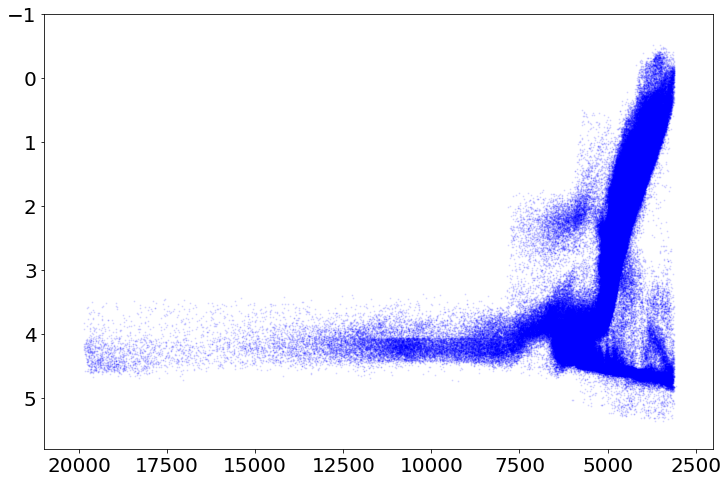

In [3]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<ipython-input-4-33b9cf6ed322>:13: RuntimeWarning: invalid value encountered in greater
  (-1<star['FE_H']) &\
<ipython-input-4-33b9cf6ed322>:14: RuntimeWarning: invalid value encountered in less
  (1>star['FE_H'])  &\
<ipython-input-4-33b9cf6ed322>:16: RuntimeWarning: invalid value encountered in greater
  (-1<star['O_FE']) &\
<ipython-input-4-33b9cf6ed322>:17: RuntimeWarning: invalid value encountered in less
  (1>star['O_FE'])&\
<ipython-input-4-33b9cf6ed322>:18: RuntimeWarning: invalid value encountered in less
  (0.5>star['O_FE_ERR'])&\
<ipython-input-4-33b9cf6ed322>:19: RuntimeWarning: invalid value encountered in less
  (0.5>star['FE_H_ERR'])


LINEAR: -0.308, 0.044
POLY2: 0.203, -0.213, 0.041
POLY3: 0.393, 0.504, -0.208,  0.031


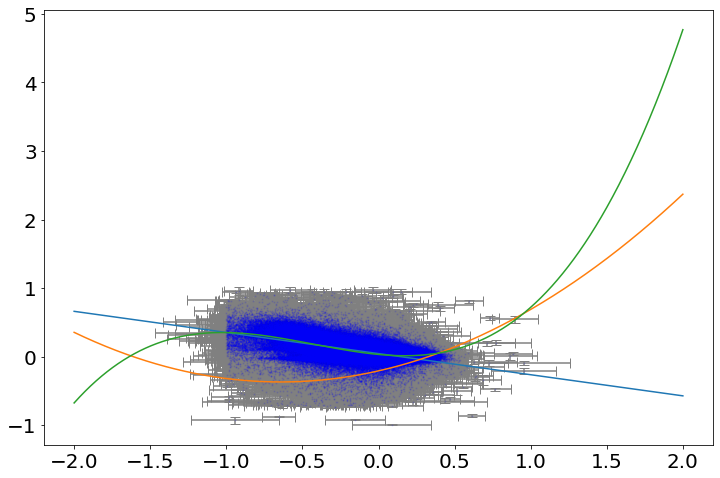

In [4]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > 20) & \
     (~np.isnan(star['FE_H'])) &\
     (-1<star['FE_H']) &\
     (1>star['FE_H'])  &\
     (~np.isnan(star['O_FE'])) &\
     (-1<star['O_FE']) &\
     (1>star['O_FE'])&\
     (0.5>star['O_FE_ERR'])&\
     (0.5>star['FE_H_ERR'])
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
FE_H_Q1 = star['FE_H'][cutQ1]
O_FE_Q1 = star['O_FE'][cutQ1]
 
ax1.scatter(FE_H_Q1,O_FE_Q1,s=1,c='b',alpha=0.1)

#=================================================================================
# LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1],p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
# POLY3 FIT (4 parameter)
polyA, polyB, polyC, polyD = mcFit4(poly3, star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1],p0=[0,0,0,0])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD: .3f}')

#=================================================================================
ax1.errorbar(star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1], ecolor='grey',fmt='none', capsize=5, zorder=0)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

x_plot = np.linspace(-2,2,1000)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3')
plt.show()

In [5]:
#For the above trends, the linear fit works seemingly the best for the constraints put on our systems.
#The best fit parameters for LINEAR are SLOPE = -0.308 and Y-INTERCEPT = 0.044.
#Yeah, the outliars from this graph have a general average at the linear fit.

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<ipython-input-6-17a49dad0fbf>:14: RuntimeWarning: invalid value encountered in greater
  (-1<star['FE_H']) &\
<ipython-input-6-17a49dad0fbf>:15: RuntimeWarning: invalid value encountered in less
  (1>star['FE_H'])  &\
<ipython-input-6-17a49dad0fbf>:17: RuntimeWarning: invalid value encountered in greater
  (-1<star['O_FE']) &\
<ipython-input-6-17a49dad0fbf>:18: RuntimeWarning: invalid value encountered in less
  (1>star['O_FE'])&\
<ipython-input-6-17a49dad0fbf>:19: RuntimeWarning: invalid value encountered in less
  (0.5>star['O_FE_ERR'])&\
<ipython-input-6-17a49dad0fbf>:20: RuntimeWarning: invalid value encountered in less
  (0.5>star['FE_H_ERR'])


LINEAR: -0.150, 0.040
POLY2: 0.103, -0.121, 0.034
POLY3: 0.295, 0.266, -0.147,  0.026


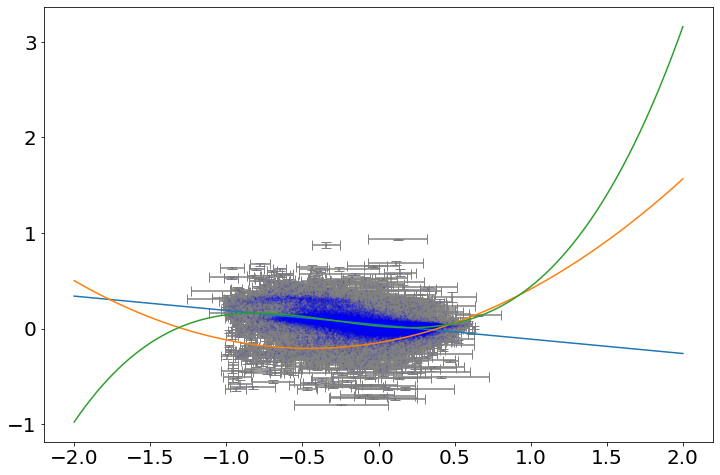

In [6]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -1) &\
     (star['GLAT']<1)&\
     (~np.isnan(star['FE_H'])) &\
     (-1<star['FE_H']) &\
     (1>star['FE_H'])  &\
     (~np.isnan(star['O_FE'])) &\
     (-1<star['O_FE']) &\
     (1>star['O_FE'])&\
     (0.5>star['O_FE_ERR'])&\
     (0.5>star['FE_H_ERR'])
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
FE_H_Q1 = star['FE_H'][cutQ1]
O_FE_Q1 = star['O_FE'][cutQ1]
 
ax1.scatter(FE_H_Q1,O_FE_Q1,s=1,c='b',alpha=0.1)

#=================================================================================
# LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1],p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
# POLY3 FIT (4 parameter)
polyA, polyB, polyC, polyD = mcFit4(poly3, star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1],p0=[0,0,0,0])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD: .3f}')

#=================================================================================
ax1.errorbar(star['FE_H'][cutQ1], star['O_FE'][cutQ1], star['FE_H_ERR'][cutQ1], \
                         star['O_FE_ERR'][cutQ1], ecolor='grey',fmt='none', capsize=5, zorder=0)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

x_plot = np.linspace(-2,2,1000)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3')
plt.show()

In [7]:
#For this Graph, poly3 fits the best because of the curving of the visible points.
#parameters of poly3 is A = 0.295, B = 0.267, C = -0.147, D = 0.026.
#outliars again generally fit around this curve but are not easily predicted by the fits.

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

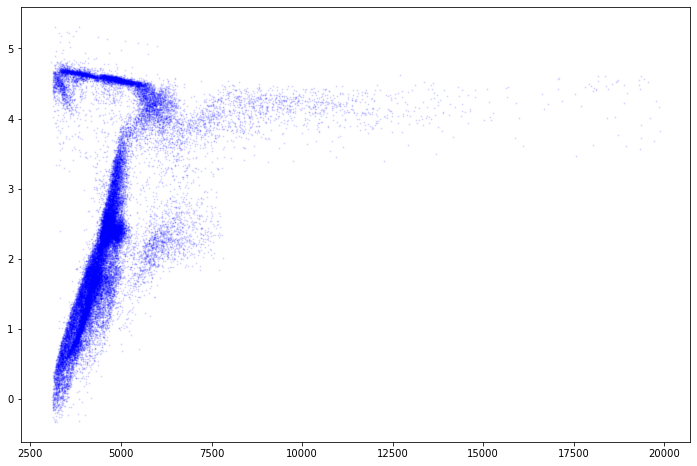

In [8]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLON'] > 340) &\
     (star['GLON']<360)&\
     (~np.isnan(star['TEFF'])) &\
     (~np.isnan(star['LOGG'])) \
     #(-1<star['FE_H']) &\
     #(1>star['FE_H'])  &\
     
     #(-1<star['O_FE']) &\
     #(1>star['O_FE'])&\
     #(0.5>star['O_FE_ERR'])&\
     #(0.5>star['FE_H_ERR'])
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
TEFF_Q3 = star['TEFF'][cutQ1]
LOGG_Q3 = star['LOGG'][cutQ1]
 
ax1.scatter(TEFF_Q3,LOGG_Q3,s=1,c='b',alpha=0.1)

LINEAR: 0.000, 0.355
exponential: -33.478, -0.000, -1.118,  4.730
POLY3: 0.000, -0.000, 0.002, -4.027


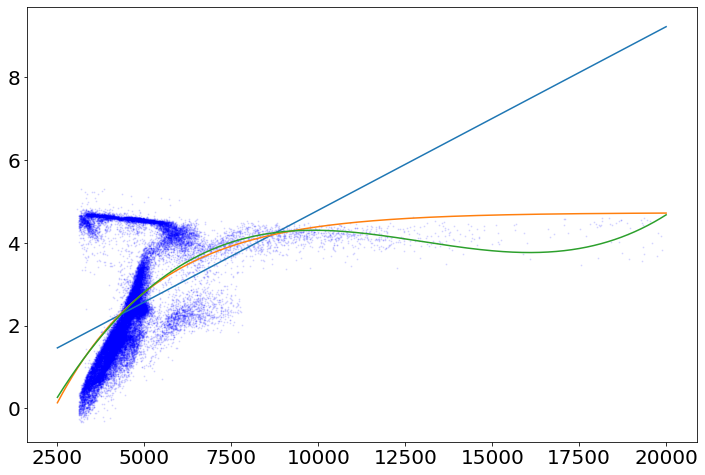

In [10]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLON'] > 340) &\
     (star['GLON']<360)&\
     (~np.isnan(star['TEFF'])) &\
     (~np.isnan(star['LOGG'])) \
     #(-1<star['FE_H']) &\
     #(1>star['FE_H'])  &\
     
     #(-1<star['O_FE']) &\
     #(1>star['O_FE'])&\
     #(0.5>star['O_FE_ERR'])&\
     #(0.5>star['FE_H_ERR'])
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
TEFF_Q3 = star['TEFF'][cutQ1]
LOGG_Q3 = star['LOGG'][cutQ1]
 
ax1.scatter(TEFF_Q3,LOGG_Q3,s=1,c='b',alpha=0.1)

#=================================================================================
# LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['TEFF'][cutQ1], star['LOGG'][cutQ1],star['TEFF_ERR'][cutQ1], \
                         star['LOGG_ERR'][cutQ1], p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# EXPONENTIAL FIT (4 parameters)
expA, expB, expC, expD = mcFit4(exponential, star['TEFF'][cutQ1], star['LOGG'][cutQ1], star['TEFF_ERR'][cutQ1], \
                         star['LOGG_ERR'][cutQ1],p0=[-73,-0.00001,-1,4.5])
print(f'exponential: {expA:.3f}, {expB:.3f}, {expC:.3f}, {expD: .3f}')

#=================================================================================
# POLY3 FIT (4 parameter)
polyA, polyB, polyC, polyD = mcFit4(poly3, star['TEFF'][cutQ1], star['LOGG'][cutQ1],star['TEFF_ERR'][cutQ1], \
                         star['LOGG_ERR'][cutQ1],p0=[0,0,0,0])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD: .3f}')

#=================================================================================
#ax1.errorbar(star['TEFF_ERR'][cutQ1], star['LOGG_ERR'][cutQ1],fmt='none', capsize=5, zorder=0)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

x_plot = np.linspace(2500,20000,10000)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#exponential fit
ax1.plot(x_plot,exponential(x_plot, expA, expB, expC, expD), label='Fit: exponential')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3')
plt.show()

## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<ipython-input-34-8e4e507c8cec>:11: RuntimeWarning: invalid value encountered in greater
  (star['RA'] > 50) &\
<ipython-input-34-8e4e507c8cec>:12: RuntimeWarning: invalid value encountered in less
  (star['RA']<120)&\
<ipython-input-34-8e4e507c8cec>:13: RuntimeWarning: invalid value encountered in less
  (star['DEC']<-50)&\


LINEAR: -0.000, 1.907
POLY2: 0.000, -0.001, 3.051


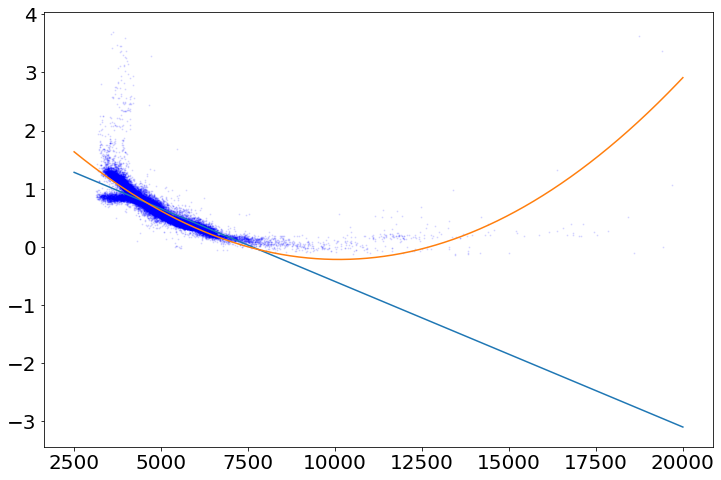

In [34]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['RA'] > 50) &\
     (star['RA']<120)&\
     (star['DEC']<-50)&\
     (~np.isnan(star['TEFF']))& \
     (~np.isnan(star['J_ERR']))&\
     (~np.isnan(star['K_ERR']))
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
TEFF_Q4 = star['TEFF'][cutQ1]
J_Q4 = star['J'][cutQ1]
K_Q4 = star['K'][cutQ1]
J_ERR_Q4 = star['J_ERR'][cutQ1]
K_ERR_Q4 = star['K_ERR'][cutQ1]
JK_Q4 = J_Q4-K_Q4
JK_ERR_Q4 = np.sqrt( J_ERR_Q4**2 + K_ERR_Q4**2 )
 
ax1.scatter(TEFF_Q4,JK_Q4,s=1,c='b',alpha=0.1)

#=================================================================================
# LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['TEFF'][cutQ1], JK_Q4 ,star['TEFF_ERR'][cutQ1], \
                         JK_ERR_Q4, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# POLY2 FIT (3 parameter)
polyA, polyB, polyC  = mcFit3(poly2, star['TEFF'][cutQ1], JK_Q4 ,star['TEFF_ERR'][cutQ1], \
                         JK_ERR_Q4,p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
# LOG FIT (4 parameter)
#logA, logB, logC, logD = mcFit4(logfit, star['TEFF'][cutQ1], JK_Q4 ,star['TEFF_ERR'][cutQ1], \
#                         JK_ERR_Q4,p0=[-1,1,1,19])
#print(f'POLY3: {logA:.3f}, {logB:.3f}, {logC:.3f}, {logD: .3f}')

#=================================================================================
#ax1.errorbar(star['TEFF_ERR'][cutQ1], star['LOGG_ERR'][cutQ1],fmt='none', capsize=5, zorder=0)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

x_plot = np.linspace(2500,20000,10000)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#log fit
#ax1.plot(x_plot,logfit(x_plot, logA, logB, logC, logD), label='Fit: logfit')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
plt.show()

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

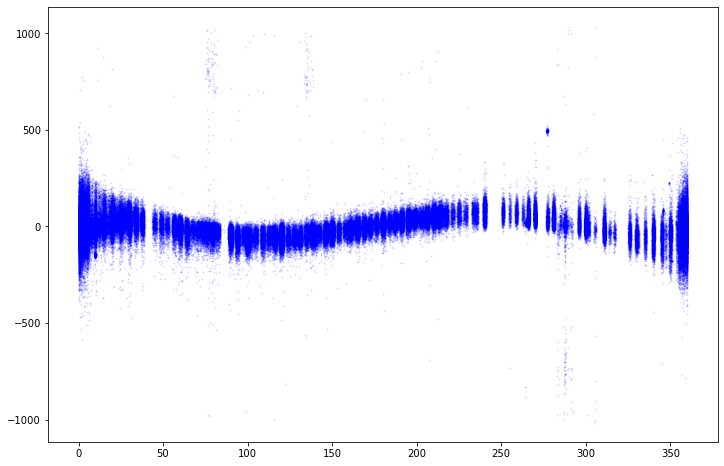

In [31]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -10) &\
     (star['GLAT']<10)&\
     (~np.isnan(star['GLON'])) &\
     (~np.isnan(star['VHELIO_AVG'])) \
     #(-1<star['FE_H']) &\
     #(1>star['FE_H'])  &\
     
     #(-1<star['O_FE']) &\
     #(1>star['O_FE'])&\
     #(0.5>star['O_FE_ERR'])&\
     #(0.5>star['FE_H_ERR'])
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
GLON_Q5 = star['GLON'][cutQ1]
VHELIO_AVG_Q5 = star['VHELIO_AVG'][cutQ1]
 
ax1.scatter(GLON_Q5,VHELIO_AVG_Q5,s=1,c='b',alpha=0.1)

LINEAR: -0.001, -3.966
cosfit: -63.273, 0.000, -0.748,  42.349
POLY3: -0.000, 0.014, -1.780,  27.951


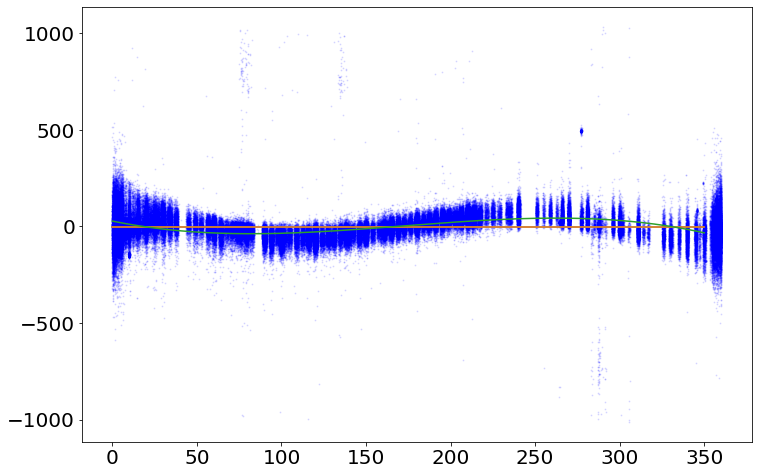

In [49]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -10) &\
     (star['GLAT']<10)&\
     (~np.isnan(star['GLON'])) &\
     (~np.isnan(star['VHELIO_AVG'])) \
     #(-1<star['FE_H']) &\
     #(1>star['FE_H'])  &\
     
     #(-1<star['O_FE']) &\
     #(1>star['O_FE'])&\
     #(0.5>star['O_FE_ERR'])&\
     #(0.5>star['FE_H_ERR'])
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
GLON_Q5 = star['GLON'][cutQ1]
VHELIO_AVG_Q5 = star['VHELIO_AVG'][cutQ1]
 
ax1.scatter(GLON_Q5,VHELIO_AVG_Q5,s=1,c='b',alpha=0.1)

#=================================================================================
# LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, GLON_Q5, VHELIO_AVG_Q5,0.5, \
                         star['VERR'][cutQ1], p0=[-.001,-3.966])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# COSFIT (4 parameters)
cosA, cosB, cosC, cosD = mcFit4(cosfit, GLON_Q5, VHELIO_AVG_Q5,0.5, \
                         star['VERR'][cutQ1],p0=[100,1/(2*np.pi*250),0,0])
print(f'cosfit: {cosA:.3f}, {cosB:.3f}, {cosC:.3f}, {cosD: .3f}')

#=================================================================================
# POLY3 FIT (4 parameter)
polyA, polyB, polyC, polyD = mcFit4(poly3, GLON_Q5, VHELIO_AVG_Q5,0.5, \
                         star['VERR'][cutQ1],p0=[-1,1,1,100])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD: .3f}')

#=================================================================================
#ax1.errorbar(star['TEFF_ERR'][cutQ1], star['LOGG_ERR'][cutQ1],fmt='none', capsize=5, zorder=0)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

x_plot = np.linspace(0,350,1000)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#exponential fit
ax1.plot(x_plot,cosfit(x_plot, cosA, cosB, cosC, cosD), label='Fit: cosfit')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3')
plt.show()

In [40]:
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

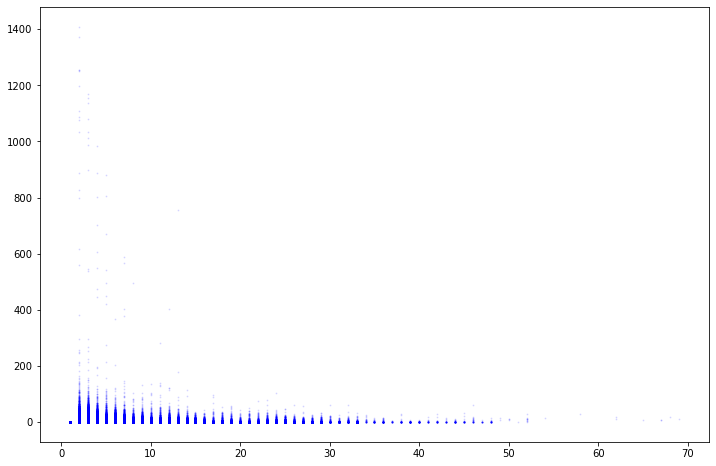

In [82]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1=(np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['NVISITS'] >= 1)&\
     (~np.isnan(star['NVISITS']))  \
    
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
NVISITS_Q6 = star['NVISITS'][cutQ1]
VSCATTER_Q6 = star['VSCATTER'][cutQ1]
 
ax1.scatter(NVISITS_Q6,VSCATTER_Q6,s=1,c='b',alpha=0.1)

LINEAR: 0.105, 0.459
POLY3: 0.000, -0.017, 0.341, -0.017


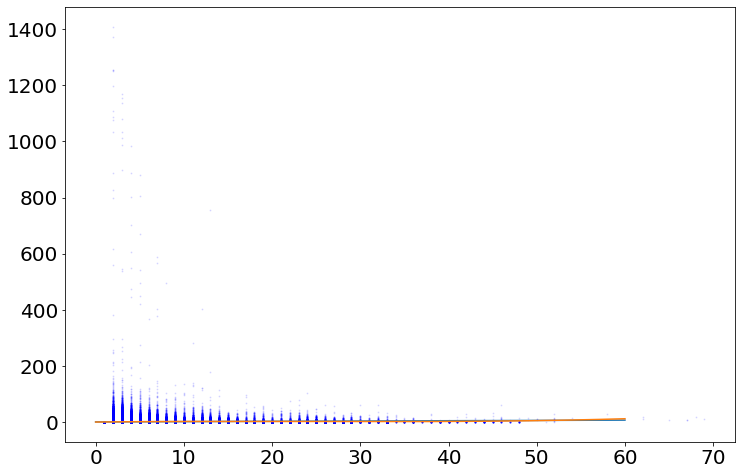

In [89]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1=(np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['NVISITS'] >= 1)&\
     (~np.isnan(star['NVISITS']))  \
    
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
NVISITS_Q6 = star['NVISITS'][cutQ1]
VSCATTER_Q6 = star['VSCATTER'][cutQ1]
 
ax1.scatter(NVISITS_Q6,VSCATTER_Q6,s=1,c='b',alpha=0.1)

#=================================================================================
# LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, NVISITS_Q6, VSCATTER_Q6,0.5, \
                         star['VERR'][cutQ1], p0=[-.001,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# expFIT (4 parameters)
#expA, expB, expC, expD = mcFit4(exponential, NVISITS_Q6, VSCATTER_Q6,0.5, \
#                         star['VERR'][cutQ1],p0=[1,0.5,0,0])
#print(f'cosfit: {expA:.3f}, {expB:.3f}, {expC:.3f}, {expD: .3f}')

#=================================================================================
# POLY3 FIT (4 parameter)
polyA, polyB, polyC, polyD = mcFit4(poly3, NVISITS_Q6, VSCATTER_Q6,0.5, \
                         star['VERR'][cutQ1],p0=[-1,1,10,100])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD: .3f}')

#=================================================================================
#ax1.errorbar(star['TEFF_ERR'][cutQ1], star['LOGG_ERR'][cutQ1],fmt='none', capsize=5, zorder=0)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

x_plot = np.linspace(0,60,1000)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#exponential fit
#ax1.plot(x_plot,exponential(x_plot, expA, expB, expC, expD), label='Fit: exponential')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3')
plt.show()

## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.005, 0.014
POLY2: 0.003, 0.011, 0.014
POLY3: -0.000, 0.002, 0.011,  0.014


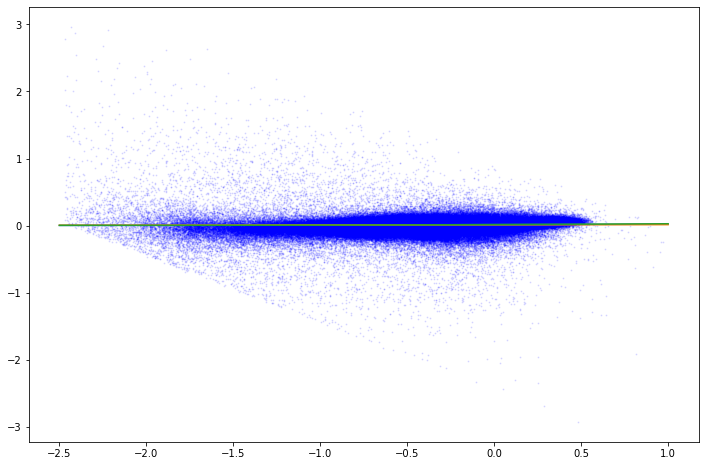

In [88]:
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

ctQ1=(np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (~np.isnan(star['FE_H']))  &\
     (~np.isnan(star['NI_FE']))  &\
     (~np.isnan(star['NI_FE_ERR']))  &\
     (~np.isnan(star['FE_H_ERR']))  
    
cutQ1 = np.where(ctQ1)[0]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
NI_FE_Q7 = star['NI_FE'][cutQ1]
FE_H_Q7 = star['FE_H'][cutQ1]
NI_FE_ERR_Q7 = star['NI_FE_ERR'][cutQ1]
FE_H_ERR_Q7 = star['FE_H'][cutQ1]
 
ax1.scatter(FE_H_Q7,NI_FE_Q7,s=1,c='b',alpha=0.1)

#=================================================================================
# LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, FE_H_Q7, NI_FE_Q7, FE_H_ERR_Q7, \
                         NI_FE_ERR_Q7, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, FE_H_Q7, NI_FE_Q7, FE_H_ERR_Q7, \
                         NI_FE_ERR_Q7,p0=[0,0,0])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
# POLY3 FIT (4 parameter)
polyA, polyB, polyC, polyD = mcFit4(poly3, FE_H_Q7, NI_FE_Q7, FE_H_ERR_Q7, \
                         NI_FE_ERR_Q7,p0=[0,0,0,0])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD: .3f}')

#=================================================================================

x_plot = np.linspace(-2.5,1,500)

#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3')
plt.show()